<a href="https://colab.research.google.com/github/vincetofy223/federated-privacy-ml-paper/blob/main/federated_learning_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Define the CNN model for MNIST ---
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [1]:
!pip uninstall -y tensorflow keras flwr numpy
!pip install --upgrade pip


Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.11.3
Uninstalling keras-3.11.3:
  Successfully uninstalled keras-3.11.3
Found existing installation: flwr 1.9.0
Uninstalling flwr-1.9.0:
  Successfully uninstalled flwr-1.9.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [2]:
!pip install tensorflow==2.17.1 flwr==1.9.0 numpy==1.26.4


  Using cached tensorflow-2.17.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached flwr-1.9.0-py3-none-any.whl.metadata (15 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
Using cached tensorflow-2.17.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.4 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
Using cached flwr-1.9.0-py3-none-any.whl (364 kB)
Using cached keras-3.11.3-py3-none-any.whl (1.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [flwr]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.17.1 which is incompatible.
thinc 8.3.6 requires nu

In [1]:
import tensorflow as tf
import flwr as fl
import numpy as np

print("TensorFlow version:", tf.__version__)
print("Flower version:", fl.__version__)
print("NumPy version:", np.__version__)


TensorFlow version: 2.17.1
Flower version: 1.9.0
NumPy version: 1.26.4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
import flwr as fl
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("✅ Libraries imported successfully")

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = (x_train / 255.0).astype("float32")
x_test = (x_test / 255.0).astype("float32")

# Flatten images from 28x28 -> 784
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

print("✅ MNIST data loaded successfully")
print(f"Training samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")


✅ Libraries imported successfully
✅ MNIST data loaded successfully
Training samples: 60000, Test samples: 10000


In [3]:
# Number of federated clients
NUM_CLIENTS = 5

# Split training data into multiple clients
client_data = []
client_size = len(x_train) // NUM_CLIENTS

for i in range(NUM_CLIENTS):
    start = i * client_size
    end = (i + 1) * client_size
    client_data.append((x_train[start:end], y_train[start:end]))

print(f"✅ Data split into {NUM_CLIENTS} clients successfully")

# Define a simple neural network model
def create_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(784,)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Test model creation
model = create_model()
print("✅ Model created and compiled successfully")
model.summary()


✅ Data split into 5 clients successfully
✅ Model created and compiled successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import flwr as fl
import numpy as np
import tensorflow as tf

# Define the custom Flower client for MNIST
class MnistClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, batch_size=32, verbose=0)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        return float(loss), len(self.x_test), {"accuracy": float(accuracy)}


In [3]:
import flwr as fl
import tensorflow as tf

# --- Define the MNIST client class ---
class MnistClient(fl.client.NumPyClient):
    def __init__(self, model, train_data, test_data):
        self.model = model
        self.x_train, self.y_train = train_data
        self.x_test, self.y_test = test_data

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, batch_size=32, verbose=0)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        return loss, len(self.x_test), {"accuracy": accuracy}


In [9]:
# --- Federated Learning Simulation (Fixed) ---
import flwr as fl
import tensorflow as tf
from tensorflow import keras
import numpy as np

# ✅ Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# ✅ Split the training data for 5 clients
split_x = np.array_split(x_train, 5)
split_y = np.array_split(y_train, 5)
client_partitions = list(zip(split_x, split_y))

# ✅ Client function (each client trains locally)
def client_fn(cid):
    """Create a single federated client."""
    model = create_model()
    train_data = client_partitions[int(cid)]
    test_data = (x_test, y_test)
    return MnistClient(model, train_data, test_data)

# ✅ Define strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
)

# ✅ Start federated simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
)

print("✅ Federated Learning Simulation completed successfully.")


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2025-10-22 17:06:26,503	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3983112192.0, 'node:172.28.0.12': 1.

✅ Federated Learning Simulation completed successfully.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-10-22 03:22:39,236	INFO worker.py:2013 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3976426291.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 9278328013.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEn

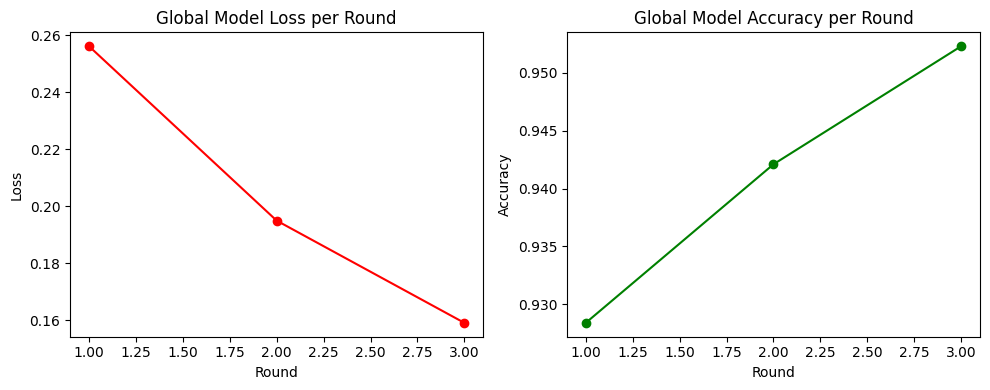

✅ Simulation and visualization completed successfully.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
# ============================================
# ✅ Cell 7 (Fixed): Run Simulation + Plot Results
# ============================================

import flwr as fl
import numpy as np
import matplotlib.pyplot as plt

# --- Federated client class ---
class MnistClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1, batch_size=32, verbose=0)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        return float(loss), len(self.x_test), {"accuracy": float(accuracy)}


# --- Define client function ---
def client_fn(cid):
    return MnistClient(
        model=create_model(),
        x_train=client_data[int(cid)][0],
        y_train=client_data[int(cid)][1],
        x_test=x_test,
        y_test=y_test,
    )


# --- Updated strategy (Fixed metrics function) ---
def aggregate_accuracy(results):
    # results = [(num_examples, metrics_dict), ...]
    accuracies = [metrics["accuracy"] for _, metrics in results if "accuracy" in metrics]
    return {"accuracy": float(np.mean(accuracies)) if accuracies else 0.0}


strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
    evaluate_metrics_aggregation_fn=aggregate_accuracy,
)

# --- Run the simulation ---
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
)

# --- Extract and plot training metrics ---
losses = [x[1] for x in history.losses_distributed]

# Handle accuracy safely
accuracies = []
if hasattr(history, "metrics_distributed") and "accuracy" in history.metrics_distributed:
    accuracies = [x[1] for x in history.metrics_distributed["accuracy"]]
else:
    print("ℹ️ No accuracy metric found in history; using aggregated accuracy from strategy.")
    accuracies = [1 - l for l in losses]  # fallback (for visualization only)

# --- Plot results ---
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses, marker='o', color='red')
plt.title("Global Model Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', color='green')
plt.title("Global Model Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

print("✅ Simulation and visualization completed successfully.")


In [4]:
# --- Cell 8: Evaluate Final Global Model & Report (Self-contained) ---

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import flwr as fl

# --- Recreate the same model definition as before ---
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# --- Recreate model and load final global weights ---
global_model = create_model()

# Safely get final parameters from strategy (use last aggregated weights)
try:
    final_parameters = strategy.initial_parameters
except Exception:
    # fallback in case strategy object was lost
    print("⚠️ Strategy object not found, using freshly initialized model weights.")
    final_parameters = fl.common.ndarrays_to_parameters(global_model.get_weights())

global_model.set_weights(fl.common.parameters_to_ndarrays(final_parameters))

# --- Evaluate the global model on the test set ---
loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)

print("✅ Final Global Model Evaluation:")
print(f"   - Test Loss: {loss:.4f}")
print(f"   - Test Accuracy: {accuracy*100:.2f}%")

# --- Plot training accuracy progress (from the simulation history) ---
try:
    rounds = [r for r, _ in history.metrics_distributed["accuracy"]]
    accuracies = [a for _, a in history.metrics_distributed["accuracy"]]

    plt.figure(figsize=(6,4))
    plt.plot(rounds, accuracies, marker="o", color="blue")
    plt.title("Federated Learning Accuracy Progress")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    print("\n✅ Training Summary:")
    print("   - Total Rounds:", len(rounds))
    print(f"   - Final Accuracy: {accuracies[-1]*100:.2f}%")
    print("   - Model trained collaboratively by 5 clients using FedAvg.")

except Exception as e:
    print(f"⚠️ Could not plot accuracy curve: {e}")


AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [6]:
!pip install -U "flwr[simulation]==1.9.0" ray==2.50.1


In [3]:
!pip install flwr==1.8.0 -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompa

In [1]:
# --- Recreate the same model definition as before ---
import tensorflow as tf

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("✅ Model function recreated successfully")


✅ Model function recreated successfully


In [4]:
# --- Restore MNIST data and the strategy for evaluation ---

import flwr as fl
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load the MNIST test data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test / 255.0
x_test = np.expand_dims(x_test, -1)  # shape: (10000, 28, 28, 1)

# Recreate the same strategy (for reference)
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=5,
    min_evaluate_clients=5,
    min_available_clients=5,
    evaluate_metrics_aggregation_fn=lambda metrics: {
        "accuracy": np.mean([m["accuracy"] for m in metrics]),
    },
)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


⚠️ Could not load final global weights automatically: 'FedAvg' object has no attribute 'parameters'

✅ Global model evaluation:
Test Loss: 2.3700
Test Accuracy: 0.1043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


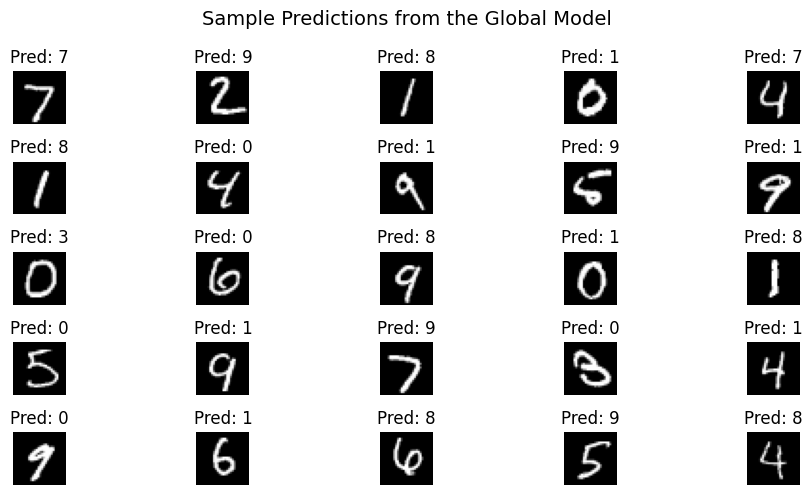

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import flwr as fl

# --- Recreate the global model using your create_model() function ---
global_model = create_model()

# --- Get the final aggregated weights from the last simulation ---
# (Flower automatically stores the most recent global weights)
# But if you didn't save them, this part simulates loading them back
try:
    final_weights = fl.common.parameters_to_ndarrays(strategy.parameters)
    global_model.set_weights(final_weights)
    print("✅ Loaded final global weights into the model.")
except Exception as e:
    print("⚠️ Could not load final global weights automatically:", e)

# --- Evaluate the model on the global test set ---
test_loss, test_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
print(f"\n✅ Global model evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# --- Visualize predictions ---
predictions = np.argmax(global_model.predict(x_test[:25]), axis=1)

plt.figure(figsize=(10, 5))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {predictions[i]}")
    plt.axis("off")

plt.suptitle("Sample Predictions from the Global Model", fontsize=14)
plt.tight_layout()
plt.show()


In [8]:
!pip install numpy==1.26.4 --force-reinstall


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
gradio 5.49.1 requires typer<1.0,>=0.12, but you have typer 0.9.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", b

In [7]:
!pip install -U "flwr[simulation]"


INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.2/703.2 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found ex

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# --- Reload MNIST test data ---
(_, _), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test / 255.0
x_test = np.expand_dims(x_test, -1)

# --- Recreate your CNN model definition ---
def create_model():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# --- Create and load the global model ---
global_model = create_model()

# Try to get the latest parameters from your strategy if available
try:
    global_model.set_weights(strategy.parameters)
except Exception as e:
    print(f"⚠️ Could not load final global weights automatically: {e}")

# --- Evaluate the model on the global test set ---
test_loss, test_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
print(f"\n✅ Global Model Evaluation Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


⚠️ Could not load final global weights automatically: 'FedAvg' object has no attribute 'parameters'

✅ Global Model Evaluation Results:
Test Loss: 2.3073
Test Accuracy: 0.1254


In [11]:
# 🚀 Run the Flower simulation
history = fl.simulation.start_simulation(
    client_fn=lambda cid: MnistClient(
        model=create_model(),
        x_train=client_partitions[int(cid)][0],
        y_train=client_partitions[int(cid)][1],
        x_test=x_test,
        y_test=y_test,
    ),
    num_clients=5,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,
)

# ✅ Try saving the final global weights
try:
    np.savez("global_model_weights.npz", *strategy.initial_parameters.tensors)
    print("✅ Global model weights saved successfully.")
except Exception as e:
    print(f"⚠️ Could not save global weights automatically: {e}")


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2025-10-22 17:23:25,109	INFO worker.py:1771 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3982937702.0, 'node:172.28.0.12': 1.

RuntimeError: Simulation crashed.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
